In [2]:
# -*- coding: utf-8 -*-
import pandas as pd
from pandas._libs.tslibs import timestamps
from datetime import datetime
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import pymysql
from  sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from datetime import datetime
import joblib
from sklearn.metrics import mean_squared_error,confusion_matrix, accuracy_score
from mpl_toolkits.mplot3d import Axes3D
Axes3D = Axes3D  # pycharm auto import
#Import the Keras libraries and packages
import tensorflow as tf
from tensorflow import keras 
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense,Dropout
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
us_bd = CustomBusinessDay(calendar=USFederalHolidayCalendar())



In [3]:
#waterlevel range 1 
mydb=pymysql.connect(host='localhost',port=int(3306),user='root',passwd='',db='sensor_data') 
query1="Select cast(timestamp as char) as Date, cast(thingName as char) as waterLevel,ROW_NUMBER() OVER (ORDER BY id) row_num, cast(value as char) as water_value FROM sensor_data WHERE thingName BETWEEN 'NIVÅ001' AND 'NIVÅ010' AND data_type='waterLevelMmAdjustedRH2000';"
df1=pd.read_sql(query1,mydb)
query2="Select cast(thingName as char) as seaLevel,ROW_NUMBER() OVER (ORDER BY id) row_num, cast(value as char) as sea_value FROM sensor_data WHERE thingName BETWEEN 'NIVÅ015' AND 'NIVÅ016' AND data_type='waterLevelMmAdjustedRH2000';"
df2=pd.read_sql(query2,mydb)
query3="Select  cast(thingName as char) as groundLevel, ROW_NUMBER() OVER (ORDER BY id) row_num, cast(value as char) as ground_value,smhi_rain  FROM sensor_data WHERE data_type='waterLevel';"
df3=pd.read_sql(query3,mydb)
    

In [4]:
#Separate dates for future plotting
df1["Date"] = pd.to_datetime(df1["Date"])
train_dates = df1["Date"] 

print(train_dates)
#print(train_dates.tail(15))#Check last few dates. 
 


# read values
#print(df1)
#print(df2)
#print(df3)
df1_1=pd.DataFrame(df1[["row_num","waterLevel","water_value"]])
df2_2=pd.DataFrame(df2[["row_num","seaLevel","sea_value"]])
df3_3=pd.DataFrame(df3[["row_num","groundLevel","ground_value","smhi_rain"]])
#print reading result
print(df1_1)
print(df2_2)
print(df3_3)
# concatniting data
#dataframe=[df3_3,df2_2,df1_1]
#df1.merge(df2_2,how='left', left_on='Column1', right_on='ColumnA')
df=pd.merge(df3_3,df1_1, on='row_num')
df_last=pd.merge(df,df2_2, on='row_num')
print(df_last)

 # x, y with sklearn convert to nump.ndarray
df_last = df_last[["water_value","smhi_rain","sea_value","ground_value"]].to_numpy()# here we have 4 variables for multiple regression. 
#y = df_last[["water_value"]].to_numpy() 
#df_last=pd.merge(x,y, on="row_num")
    #print(x)
print(df_last)

0       2021-05-04 23:54:52
1       2021-05-04 23:44:49
2       2021-05-04 23:34:55
3       2021-05-04 23:04:51
4       2021-05-04 22:54:48
                ...        
75988   2021-08-04 04:57:53
75989   2021-08-04 03:50:07
75990   2021-08-04 03:01:40
75991   2021-08-04 02:00:38
75992   2021-08-04 00:58:32
Name: Date, Length: 75993, dtype: datetime64[ns]
       row_num waterLevel water_value
0            1    NIVÅ001        1673
1            2    NIVÅ001        1673
2            3    NIVÅ001        1674
3            4    NIVÅ001        1674
4            5    NIVÅ001        1674
...        ...        ...         ...
75988    75989    Nivå004         776
75989    75990    Nivå004         784
75990    75991    Nivå004         789
75991    75992    Nivå004         795
75992    75993    Nivå004         803

[75993 rows x 3 columns]
      row_num seaLevel sea_value
0           1  Nivå016        79
1           2  Nivå016       103
2           3  Nivå016       111
3           4  Nivå016       

In [5]:
# change the data type to avoid array problem
#x=x.astype(np.float64,copy=False)
#y=y.astype(np.float64,copy=False)
#LSTM uses sigmoid and tanh that are sensitive to magnitude so values need to be normalized

In [6]:
# normalize the dataset
scaler = StandardScaler()
scaler=scaler.fit(df_last)
df_x=scaler.transform(df_last)
# splitting the data
#x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 0)
#print(x_train)
#print(y_train)

In [7]:
#As required for LSTM networks, we require to reshape an input data into n_samples x timesteps x n_features. 
#In this example, the n_features is 4. We will make timesteps = 15 (past days data used for training). 

#Empty lists to be populated using formatted training data
x_train = []
y_train = []

n_future = 1   # Number of days we want to look into the future based on the past days.
n_past = 15  # Number of past days we want to use to predict the future.

#Reformat input data into a shape: (n_samples x timesteps x n_features)
#the df_x has a shape (3208, 4)
#3208 refers to the number of data points and 4 refers to the columns (multi-variables).
for i in range(n_past, len(df_x) - n_future +1):
    x_train.append(df_x[i - n_past:i, 0:df_x.shape[1]])
    y_train.append(df_x[i + n_future - 1:i + n_future, 0])

x_train,y_train = np.array(x_train), np.array(y_train)

print(x_train)
print(y_train)
print('x_train shape == {}.'.format(x_train.shape))
print('y_train shape == {}.'.format(y_train.shape))

[[[ 0.76394755  1.21278972 -0.21220018 -0.47799776]
  [ 0.76394755  1.21278972  0.02446945 -0.47799776]
  [ 0.76537059  1.21278972  0.10335933 -0.47799776]
  ...
  [ 0.77248579  1.21278972  0.14280426 -0.47799776]
  [ 0.77248579  1.21278972  0.42878006 -0.47799776]
  [ 0.77248579  1.21278972  0.09349809 -0.47799776]]

 [[ 0.76394755  1.21278972  0.02446945 -0.47799776]
  [ 0.76537059  1.21278972  0.10335933 -0.47799776]
  [ 0.76537059  1.21278972  0.33016772 -0.47799776]
  ...
  [ 0.77248579  1.21278972  0.42878006 -0.47799776]
  [ 0.77248579  1.21278972  0.09349809 -0.47799776]
  [ 0.77248579  1.21278972  0.38933513 -0.47799776]]

 [[ 0.76537059  1.21278972  0.10335933 -0.47799776]
  [ 0.76537059  1.21278972  0.33016772 -0.47799776]
  [ 0.76537059  1.21278972  0.48794747 -0.47799776]
  ...
  [ 0.77248579  1.21278972  0.09349809 -0.47799776]
  [ 0.77248579  1.21278972  0.38933513 -0.47799776]
  [ 0.77533187  1.21278972  0.22169414 -0.47799776]]

 ...

 [[-0.4257137  -0.82454525  1.4346

In [8]:
# define the Autoencoder model

model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(x_train.shape[1], x_train.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(y_train.shape[1]))

model.compile(optimizer='adam', loss='mse',metrics=['mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error'])
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 15, 64)            17664     
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 30,113
Trainable params: 30,113
Non-trainable params: 0
_________________________________________________________________


Epoch 1/5
181/181 [==============================] - 38s 19ms/step - loss: 0.3289 - mean_squared_error: 0.3289 - mean_absolute_error: 0.4285 - mean_absolute_percentage_error: 45.1286 - val_loss: 0.1639 - val_mean_squared_error: 0.1639 - val_mean_absolute_error: 0.2286 - val_mean_absolute_percentage_error: 21.9270
Epoch 2/5
181/181 [==============================] - 2s 12ms/step - loss: 0.0800 - mean_squared_error: 0.0800 - mean_absolute_error: 0.1814 - mean_absolute_percentage_error: 19.6825 - val_loss: 0.0794 - val_mean_squared_error: 0.0794 - val_mean_absolute_error: 0.1672 - val_mean_absolute_percentage_error: 17.9631
Epoch 3/5
181/181 [==============================] - 2s 11ms/step - loss: 0.0510 - mean_squared_error: 0.0510 - mean_absolute_error: 0.1528 - mean_absolute_percentage_error: 17.2023 - val_loss: 0.0518 - val_mean_squared_error: 0.0518 - val_mean_absolute_error: 0.0914 - val_mean_absolute_percentage_error: 10.6591
Epoch 4/5
181/181 [==============================] - 2s 1

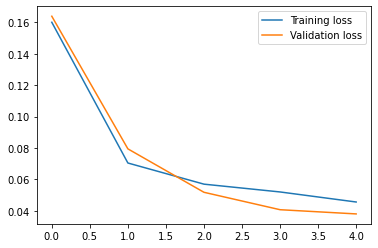

In [9]:
# fit the model
history = model.fit(x_train, y_train, epochs=5, batch_size=16, validation_split=0.1, verbose=1)

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()



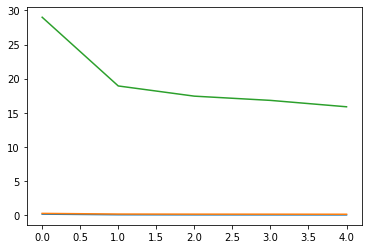

In [10]:
# plot metrics
plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['mean_absolute_percentage_error'])

plt.show()

        Date  Water_Level_last
0 2021-09-10       1099.735107
1 2021-09-11       1100.006348
2 2021-09-12       1100.231567
3 2021-09-13       1100.402466
4 2021-09-14       1100.525757
5 2021-09-15       1100.612671
6 2021-09-16       1100.670166
                     Date water_value
75986 2021-08-04 06:55:54         768
75987 2021-08-04 06:01:35         771
75988 2021-08-04 04:57:53         776
75989 2021-08-04 03:50:07         784
75990 2021-08-04 03:01:40         789
75991 2021-08-04 02:00:38         795
75992 2021-08-04 00:58:32         803


C:\Users\alha1207\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Date', ylabel='Water_Level_last'>

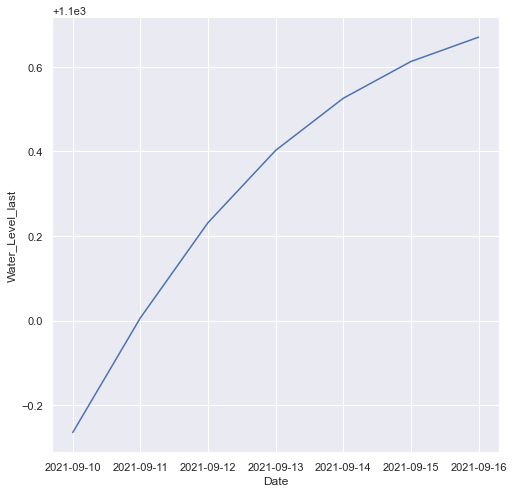

In [379]:
n_future=7
#n_past = 16
#n_days_for_prediction=15
#print(train_dates)
#train_dates=pd.to_datetime(pd.Series(df1["Date"]))
#print(train_dates)
#list(train_dates)[-1]
forecast_period_dates = pd.date_range(start=datetime.now(), periods=n_future, freq='1D').tolist()
#print(forecast_period_dates)
#predict the next 7 days
#print(x_train)
forecast = model.predict(x_train[-n_future:])
#print(forecast)
forecast_copies =np.repeat(forecast, df_last.shape[1],axis=-1)
y_pred_future = scaler.inverse_transform(forecast_copies)[:,0]
#print(forecast_copies)
#print(y_pred_future)
# Convert timestamp to date
forecast_dates = []
for time_i in forecast_period_dates:
    forecast_dates.append(time_i.date())
df_forecast = pd.DataFrame({'Date':np.array(forecast_dates), 'Water_Level_last':y_pred_future})
df_forecast["Date"]=pd.to_datetime(df_forecast["Date"])
print(df_forecast)

original = df1[["Date","water_value"]]
original = original.tail(7)
print(original)
#original["Date"]=df1["Date"]
#original = original.loc[original["Date"] >= '2021-8-4']
#print(original)
#sns.set(rc={'figure.figsize':(8,8)})
#sns.lineplot(original["Date"], original["water_value"])
sns.lineplot(df_forecast["Date"], df_forecast["Water_Level_last"])




In [15]:
#test values
predicted_waterLevel = df_forecast["Water_Level_last"] 
print("Water Level for next 7 days :\n",predicted_waterLevelt) 
for i in predicted_waterLevel:
    if(i > 800): 
         print("Will flood soon") 
    else:
         print("Water level is OK") 
dir='C:\\Users\\alha1207\\ANN\\output\\'
filename ='ANN_model_1.sav' 
joblib.dump(predicted_waterLevel, dir + filename)

NameError: name 'df_forecast' is not defined

In [402]:
## database cloding 
mydb.close() #close the connection
print("Database closed!")

Database closed!
